In [24]:
import random as rn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time as ti
import itertools as it
from IPython.display import display, Latex

Disclaimer: I will ommit comments from code where I feel the context or variable names etc clearly illustrate things.

# Creating a simulation of blackjack

Firstly I initialise the deck which contains 52 cards. I include the suit but that is not essential as blackjack outcomes are invaraint of suit:

In [25]:
full_deck = ["2","3","4","5","6","7","8","9","10","J","Q","K","A"]*4

We now have to calculate the score associated with a given hand. We must assign a dynamic rule to the ace which sets all aces equal to eleven initially. I the hand is bust, the first ace is set to 1. If still bust the first two aces are set to 1 and so on:

In [26]:
def score(current_hand):
    score = 0
    high_aces = 0
    low_aces = 0
    for i in current_hand:
        if i[0] != "A":
            if i.isdigit() and int(i) > 1:
                 score += int(i)
            else:
                 score += 10
        if i[0] == "A": 
            high_aces += 1
        
    while high_aces > 0:
        if score + 11*high_aces + low_aces < 22:
            score += 11*high_aces 
            high_aces = 0
        if score + 11*high_aces + low_aces > 21:
            high_aces -= 1
            low_aces += 1

    return score + low_aces

## Object Oriented Programming
For the model I will employ 3 objects. These are classes which have class specific methods. The objects are the deck, the player and the game and they all are required so apply several actions via their methods:

### The Deck
The deck must:
- Show deck in its current state
- Draw from the deck in its current state
- Remove specified cards from the deck

In [27]:
class deck:
    def __init__(self, num_decks = 1):
        self.deck = list(np.random.permutation(full_deck*num_decks))
    def show_deck(self):
        return(self.deck)
        
    def draw(self):
        if len(self.deck) > 0:
            x = self.show_deck().pop()
            return(x)
            self.deck.remove(x)   

        else:
            return(None)
        
    def remove(self,to_be_removed):
        for i in to_be_removed:
            self.deck.remove(i)


### The Player
The player must:
- Show hand
- Draw new card given a deck
- Insert a specified card to their hand (Essential for the dealer's hidden card and for simulating specific hands)

In [28]:
class player:
    def __init__(self):
        self.current_hand = []
        
    def show_hand(self):
        return(self.current_hand)
    
    def draw(self,current_deck):
        self.current_hand = list(self.current_hand) + [current_deck.draw()]#needs work
            
    def take_card(self,hidden_card):
        self.current_hand = np.append(self.current_hand,hidden_card)
        
    def score(self):
        return score(self.current_hand)

### The Game
The game must:
- Initialize dealer, player, game, deck given a number of decks
- Perform the initial deal giving the player two visible cards and giving the dealer one visible card and one hidden card
- Be capable of fixing the hands of both dealer and player for my analysis
- At any point show the hands of both parties, the hidden card or the deck

In [29]:
class game:
    def __init__(self,num_decks = 1, player_initial_hand = [], dealer_initial_hand = []):

        #Add initial hand method that draws etc

        self.player = player()
        self.dealer = player()
        self.deck = deck(num_decks)
        
        self.deck.remove(list(player_initial_hand) + list(dealer_initial_hand))
            
        for j in player_initial_hand:
            self.player.take_card(j)
            
        while len(self.player.show_hand()) < 2:
            self.player.draw(self.deck)
        
            
        for j in dealer_initial_hand:
            self.dealer.take_card(j)
            
        if len(self.dealer.show_hand()) < 2:
            self.dealer.draw(self.deck)
        
# Define functions to show the hands, hidden card and current deck
    def show_player(self):
        return(self.player.show_hand())

    def show_dealer(self):
        return(self.dealer.show_hand())
    
    def show_hidden(self):
        return(self.hidden_card)
    
    def show_deck(self):
        return(self.deck.show_deck())

## Startegy
I will employ several strategies for playing the games, each one using different levels of complexity and thereofre implied player skill. The first strategy will be for a layman with no knowledge or interest in the game. For this person, I will determine the best value for them to stick at to maximize their win rate. 
### Layman Startegy

I run the game drawing two cards for the player and dealer. For each possible stick value $i \in [10,21]$ I will simulate $10^6$ games and where the player sticks if their hand has a score $\geq i$. I will then present the win, loss, tie proportions for each stick threshold. Firstly I define a function which determines the winner or if a tie has taken place:

In [30]:
def decision(player,dealer):
    if player.score() < 22:#Not bust
        if player.score() > dealer.score():#Player Wins
            return([1,0,0], player.show_hand())

        if player.score() < dealer.score() and dealer.score() < 22:#Dealer Wins
            return([0,1,0], dealer.show_hand())

        if dealer.score() > 21:#Dealer bust
            return([1,0,0], [])

        if player.score() == dealer.score():#Tie
            return([0,0,1], [])
    if player.score() > 21: #Player bust
        return(np.array([0,1,0]), [])

I now run the simulations with the player sticking if they score on or above $i$:

In [31]:
totals = {}
    
total_iterations = 10**5

start = ti.time()
for i in range(10,22):
    iterations = total_iterations
    current_score = np.array([0,0,0])
    while iterations > 0:
        test = game()
 
        while test.player.score() < i:
            test.player.draw(test.deck)

        while test.dealer.score() < 17:
            test.dealer.draw(test.deck)
#--------------------------------------------------------------------------------
        temp, hand = decision(test.player, test.dealer)#[1,0,0] for player win, [0,1,0] for dealer win, [0,0,1] for tie
        current_score += temp
#------------------------------------------------------------------------------------
        iterations -= 1
    totals[str(i)] = current_score
ti.time() - start

90.45321750640869

In [32]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i], round(y[i],4), round(y[i],4), ha = 'center',
                 bbox = dict(facecolor = 'red', alpha =.8))

In [45]:
def custom_hist(labels, data, xlabel = None, ylabel = None, title = None, boxes = False, proportions = (12,5), round_to = 4):
    if proportions != []:
        fig = plt.figure(figsize=proportions)
    plt.bar(labels, data, color = "red")
    plt.grid()
    if boxes == True:
        for i in range(len(labels)):
            plt.text(labels[i], round(data[i],4), round(data[i],round_to), ha = 'center', va = "bottom",bbox = dict(facecolor = 'red', alpha =.8))

The below histogram shows how often the player wins with a given startegy and the black line shows the dealer bust rate which is the baseline for any strategy as this level can be exceeded by simply sticking on the draw:

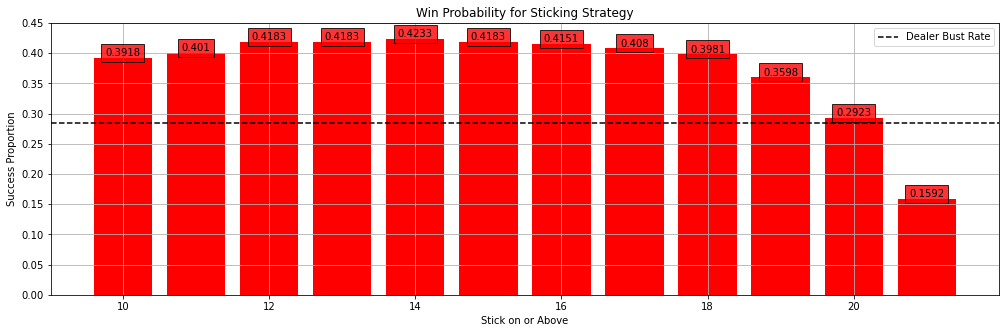

In [34]:
custom_hist(range(10,22), [i[0]/10**5 for i in totals.values()], boxes = True, proportions = (17,5))
plt.axhline(y=.285, color='black', linestyle='--', label = "Dealer Bust Rate")
plt.title("Win Probability for Sticking Strategy")
plt.xlabel("Stick on or Above")
plt.ylabel("Success Proportion")
plt.ylim(0,0.45)
plt.legend()
#plt.savefig("Simple_Strategy.png", dpi = 300, bbox_inches='tight')

We identify holding at 14 or above as the optimal holding value. I will simulate $10^6$ games with this stategy to determine some properties of the game. These will include:
- Number of cards in winners hand
- Types of cards in winners hand
- Win, draw, tie rate
This will illustrate how different cards are more likely to result ina  win if present in a hand.

In [55]:
#------------------------------------------------------------------------------------
cards_in_hand = dict([(key, 0) for key in full_deck[0:13] + ["non_bust_wins"]])

num_cards = dict([key,0] for key in range(2,9))
#------------------------------------------------------------------------------------
    
iterations, current_score = 10**6, np.array([0,0,0])

start = ti.time()

while iterations > 0:
    test = game()

    while test.player.score() < 14:
        test.player.draw(test.deck)

    while test.dealer.score() < 17:
        test.dealer.draw(test.deck)

    temp, hand = decision(test.player, test.dealer)#[1,0,0] for player win, [0,1,0] for dealer win, [0,0,1] for tie
    
    current_score += temp
    if len(hand) != 0 and temp == [1,0,0]: #Dont include bust victories, their victory is because of the other players failing rather than the hand quality
        num_cards[len(hand)] += 1     
        cards_in_hand["non_bust_wins"] += 1
        for card in hand:
            cards_in_hand[card] += 1
            
        

#------------------------------------------------------------------------------------ 
    iterations -= 1
ti.time() - start

79.2874903678894

In [57]:
# Average cards when someone wins against a valid hand
ave_cards = 0
for i,j in zip(num_cards.keys(), num_cards.values()):
    ave_cards += i*j
ave_cards = ave_cards/cards_in_hand["non_bust_wins"]

We not the following is for sticking on soft 14 or more which means the max size of a hand is 7:

22223AA[Finish on card below 9]

In [58]:
cs_winning = [sum(list(num_cards.values())[:i])/sum(num_cards.values()) for i in range(1,10)] # The number of cards in the winning hand cumulative sum
print("Looking up to three draws gets:", str(round(cs_winning[3],7)), "of all winning hands")
print("Looking up to four draws gets:", str(round(cs_winning[4],7)), "of all winning hands")
av_cards = sum(num_cards.values())/cards_in_hand["non_bust_wins"] 
print("Average cards per winning hand:",str(round(ave_cards,4)))

Looking up to three draws gets: 0.9997919 of all winning hands
Looking up to four draws gets: 1.0 of all winning hands
Average cards per winning hand: 2.4412


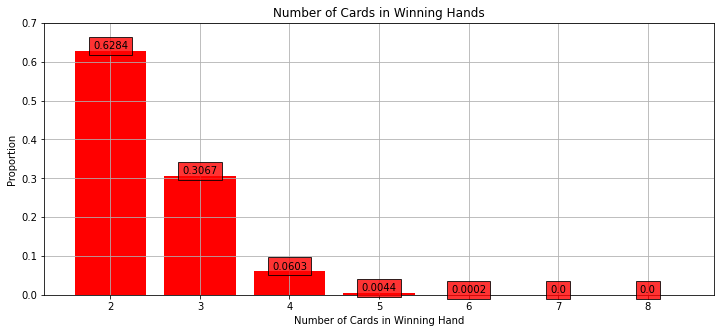

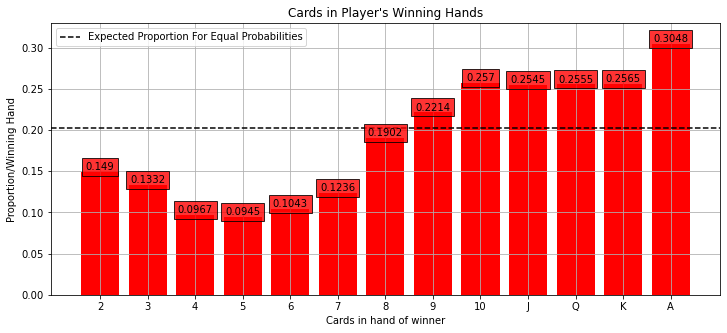

In [67]:
custom_hist(range(2,9), [i/sum(num_cards.values()) for i in num_cards.values()][:7], boxes = True)

plt.ylim(0,.7)
plt.title("Number of Cards in Winning Hands")
plt.xlabel("Number of Cards in Winning Hand")
plt.ylabel("Proportion")
plt.show()

temp = pd.read_csv("Cards_Winning_Hand.csv", index_col = 0)
custom_hist(range(0,13),[i/cards_in_hand["non_bust_wins"] for i in list(cards_in_hand.values())[:-1]], boxes = True)
plt.axhline(y=1/13*2.639, color='black', linestyle='--',  label = "Expected Proportion For Equal Probabilities")
plt.title("Cards in Player's Winning Hands")
plt.xlabel("Cards in hand of winner")
plt.ylabel("Proportion/Winning Hand")
plt.ylim(0,.33)
plt.xticks(range(0,13), full_deck[0:13])
plt.legend(loc='upper left')

### A GIF for the README File

In [39]:
full_deck = ["2","3","4","5","6","7","8","9","10","J","Q","K","A"]*4
total_iterations = 10**4
prob_evolution = {}
probabilities = []
for i in full_deck[0:13]:
    prob_evolution[i] = 0
full_deck.remove("2")
full_deck.remove("2")
while total_iterations > 0:
    prob_evolution[full_deck[np.random.randint(0,50)]] += 1
    total_iterations -= 1
    if total_iterations % 10**2 == 0:
        temp =  np.array(list(prob_evolution.values()))
        probabilities.append(temp/sum(temp))
full_deck = ["2","3","4","5","6","7","8","9","10","J","Q","K","A"]*4

In [40]:
count = 0
for j in probabilities:
    fig = plt.figure(figsize=[10,10])
    plt.text(-.05, -0.07,  "[2, 2]")
    for i in range(-6,7):
        plt.plot([0,.5],[0,i], "k")
        plt.text(0.52, i, "[2,2," + str(list(prob_evolution.keys())[6+i]) + "] Pr = " +  "%.5f" % round(j[6+i], 5))


    plt.plot([0],[0], "rX")
    plt.xlim(-.1,.7)
    plt.axis('off')
    #plt.savefig(str(count)+".png", dpi = 100)
    plt.close(fig)
    count += 1

### I will now answer the question "How often does the dealer go bust?":

In [41]:
total_iterations = 10**6
scores = dict([str(key),0] for key in range(2,30))
iterations = total_iterations
bust = 0
start = ti.time()
for i in range(10,22):
    while iterations > 0:
        test = game()

        while test.dealer.score() < 17:
            test.dealer.draw(test.deck)
            
        if  test.dealer.score() > 21:
            bust += 1
        scores[str(test.dealer.score())] += 1

        iterations -= 1
ti.time() - start

61.90742087364197

Text(0, 0.5, 'Proportion')

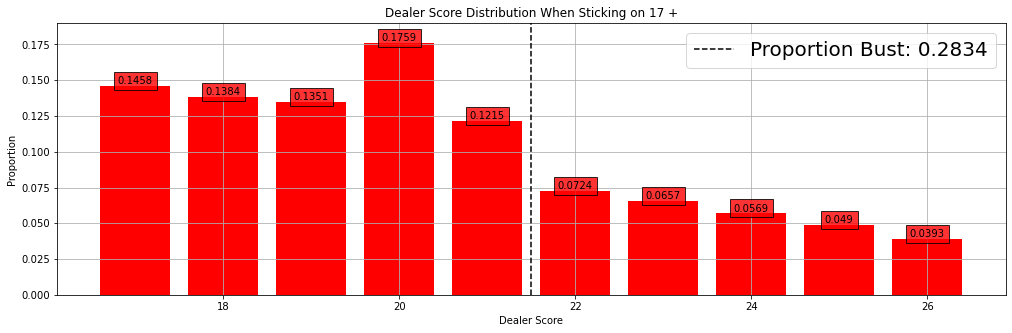

In [42]:
custom_hist(range(17,27),[i/sum([i for i in scores.values() if i != 0]) for i in scores.values() if i != 0], boxes = True, proportions = (17,5))
plt.axvline(x=21.5, color='black', linestyle='--',  label = "Expected Proportion For Equal Probabilities")
plt.legend(["Proportion Bust: " + str(round(bust/total_iterations,4))], loc='upper right',prop={'size': 20})
plt.ylim(0,0.19)
plt.title("Dealer Score Distribution When Sticking on 17 +")
plt.xlabel("Dealer Score")
plt.ylabel("Proportion")
#plt.savefig("Dealer_Score_Dist.png", dpi = 700, bbox_inches='tight')

### For the dealers first card, what is his final score distribution since we dont know the hidden card?

In [43]:
total_iterations = 10**5
percard = dict([str(key),0] for key in range(17,27))
scores = {}

start = ti.time()
for card in np.unique(full_deck):
    iterations = total_iterations
    percard = dict([str(key),0] for key in range(17,27))
    while iterations > 0:
        test = game(dealer_initial_hand = [card])
        while test.dealer.score() < 17:
            test.dealer.draw(test.deck)


        percard[str(test.dealer.score())] += 1
        iterations -= 1
    scores[str(card)] = percard 
ti.time() - start

99.00707411766052

I now make histograms corresponding to the final dealer score distributon if the dealer's visible card is that shown in the title:

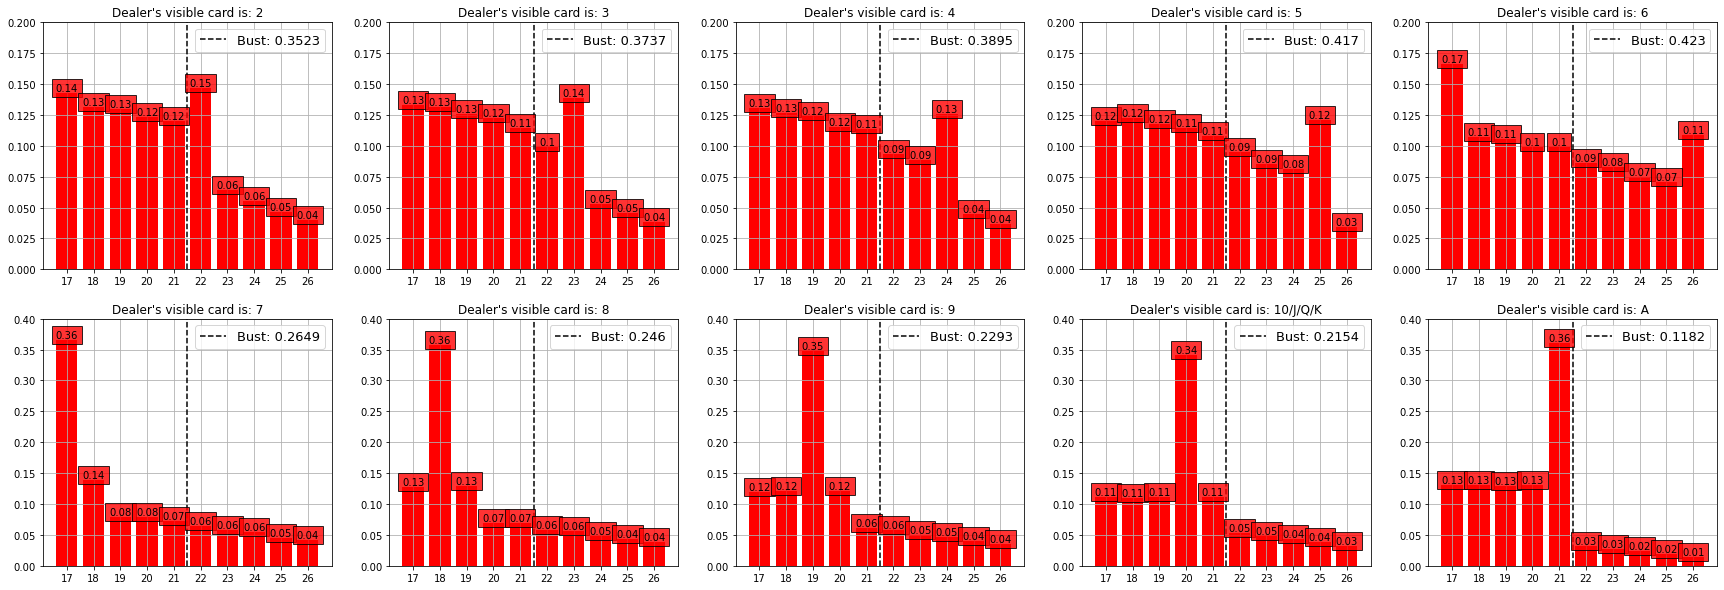

In [46]:
fig = plt.figure(figsize=(30,10))
for i in range(0,10):
    ax = fig.add_subplot(2,5,i+1)
    #Fix then blow into proportions
    current_card = ['2', '3', '4', '5', '6', '7', '8', '9','10', 'A'][i]
    plt.axvline(x=4.5, color='black', linestyle='--',  label = "Expected Proportion For Equal Probabilities")
    custom_hist(list(scores[current_card].keys()),np.array(list(scores[current_card].values()))/sum(list(scores[current_card].values())), boxes = True, proportions = [], round_to = 2)
    bust = sum(list(scores[current_card].values())[5:])
    plt.legend(["Bust: " + str(round(bust/100000,4))], loc='upper right',prop={'size': 13})
    if current_card == "10":
        current_card = "10/J/Q/K"
    ax.title.set_text("Dealer's visible card is: " + str(current_card))
    #ax.legend(loc='upper right')
    if i < 5:
        ax.set_ylim([0,.2])
    if i >= 5:
        ax.set_ylim([0,.4])
plt.show()
#plt.savefig("Dealer_Complete_score.png", dpi = 300, bbox_inches='tight')